# Explore COUGHVID Dataset
### Aim: Describe audio data and metadata using visualisations and summary statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
import seaborn as sns
import random
from collections import Counter
import scipy.stats as stats

In [4]:
PATH_TO_AUDIO = 'wav_recordings/'
metadata = pd.read_csv('coughvid-19/metadata_compiled.csv')
print(f'Records prior to filtering: {len(metadata)}')
print(metadata.status.value_counts())
metadata = metadata[metadata.cough_detected >= 0.8]  # recommended by dataset creators
metadata = metadata.reset_index(drop = True)
print(f'Records post filtering: {len(metadata)}')
print(metadata.status.value_counts())


Records prior to filtering: 27550
healthy        12479
symptomatic     2590
COVID-19        1155
Name: status, dtype: int64
Records post filtering: 15125
healthy        8300
symptomatic    1820
COVID-19        699
Name: status, dtype: int64


In [5]:
metadata.head()

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952,2020-05-24T12:12:46.394647+00:00,0.8937,13.477551,NaN,NaN,28.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00291cce-36a0-4a29-9e2d-c1d96ca17242,2020-04-13T15:10:58.405156+00:00,0.9883,14.603851,39.4,67.2,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[]

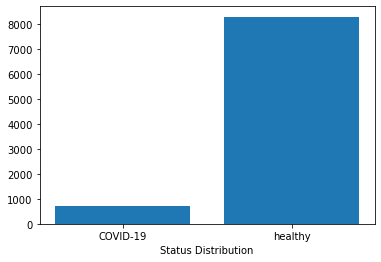

In [46]:
fig, ax = plt.subplots()

vis_df = metadata[['status', 'uuid']][metadata.status.isin(['healthy', 'COVID-19'])]

vis_df = vis_df.groupby('status').agg('count').reset_index()
vis_df.columns = ['status', 'count']

x = list(vis_df.status)
x_pos = [i for i, _ in enumerate(x)]
counts = list(vis_df['count'])

ax.bar(x_pos, counts)

plt.xlabel('Status Distribution')
plt.xticks(x_pos, x)
plt.plot()

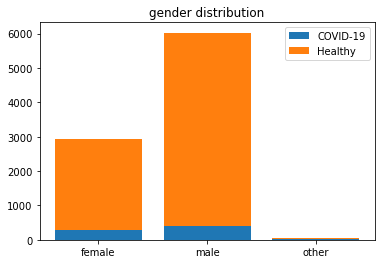

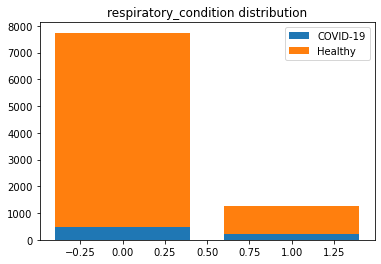

In [4]:
# visually analyse key metadata 
# compare distributions and overlay covid-19 status

key_vars = ['gender', 'respiratory_condition']  #doing age separately

for var in key_vars:
    vis_df = metadata[['uuid', var, 'status']].groupby([var, 'status']).agg('count')
    vis_df.reset_index(inplace = True)

    fig, ax = plt.subplots()
    
    ax.bar(vis_df[vis_df.status == 'COVID-19'][var],
        vis_df[vis_df.status == 'COVID-19']['uuid'], label = 'COVID-19')
    ax.bar(vis_df[vis_df.status == 'healthy'][var],
        vis_df[vis_df.status == 'healthy']['uuid'], bottom=vis_df[vis_df.status == 'COVID-19']['uuid'], label = 'Healthy')
    ax.legend()
    ax.set_title(f'{var} distribution')


[]

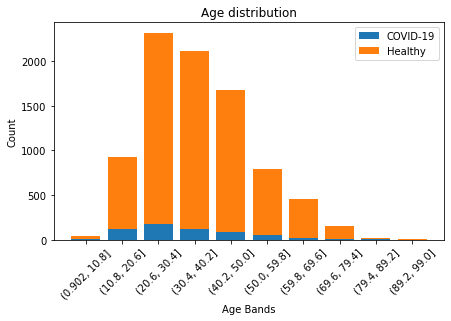

In [5]:
age_df = metadata[['age', 'status']].groupby(['status', pd.cut(metadata['age'], 10)]).size()
age_df = age_df.reset_index()
age_df = age_df.rename(columns={age_df.columns[2] : 'count'})
age_df.age = age_df.age.astype('str')

fig, ax = plt.subplots(figsize = (7,4))
    
ax.bar(age_df[age_df.status == 'COVID-19']['age'],
    age_df[age_df.status == 'COVID-19']['count'], label = 'COVID-19')
ax.bar(age_df[age_df.status == 'healthy']['age'],
    age_df[age_df.status == 'healthy']['count'], bottom=age_df[age_df.status == 'COVID-19']['count'], label = 'Healthy')

ax.set_xlabel('Age Bands')
ax.set_ylabel('Count')

ax.legend()
ax.set_title('Age distribution')
plt.xticks(rotation = 45)
plt.plot()

### Explore audio data
Take sample of audio clips
- Check number of channels in each clip
- Check audio lengths
- Check sampling rates of audio clips

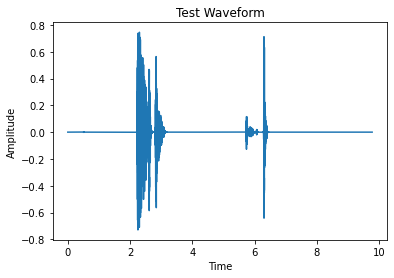

In [6]:
# Load and plot test waveform

def plot_waveform(sample, sample_rate, x_label = 'Time', y_label= 'Amplitude', title = None):
    """
    sample: signal from audio file
    sample_rate: sample rate from sample
    x_label, y_label, title: specify if different from defaults
    """
    sample_length = len(sample)/sample_rate
    time_stamps = np.linspace(0, sample_length, int(sample_length*sample_rate))

    plt.plot(time_stamps, signal)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if title:
        plt.title(title)
    plt.show()

test_uuid = metadata.uuid[0]
signal, sample_rate = librosa.load(f'{PATH_TO_AUDIO}{test_uuid}.wav')

plot_waveform(signal, sample_rate, title = 'Test Waveform')

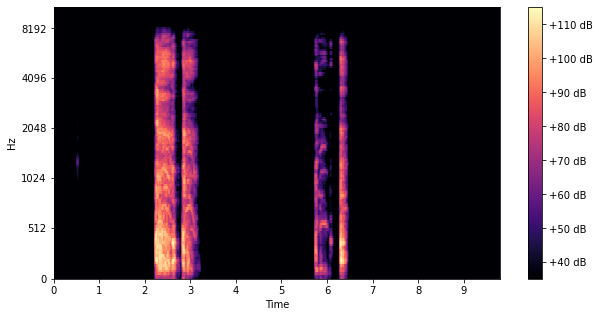

In [7]:
sgram =librosa.stft(signal)
#librosa.display.specshow(sgram)

sgram_mag, _= librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
#librosa.display.specshow(mel_scale_sgram)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref = np.min)
fig, ax = plt.subplots(figsize=(10,5))
librosa.display.specshow(mel_sgram, sr = sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [8]:
uuids = random.sample(list(metadata.uuid), 2500)  # sample of 1000 uuid for testing
#uuids = list(metadata.uuid)  # too much data to do quick analysis, have checked that all audio is same sample rate (it is)

In [9]:
# create dictionary of data
audio_dict = {'signals' : [], 'sample_rates' : []}
for uuid in uuids:
    signal, sample_rate = librosa.load(f'{PATH_TO_AUDIO}{uuid}.wav')
    audio_dict['signals'].append(signal)
    audio_dict['sample_rates'].append(sample_rate)

# number of channels per audio file
channel_counts = []
for signal in audio_dict['signals']:
    channel_counts.append(len(signal.shape))

# sample duration investigation
sample_lengths = np.array([])
for sample in audio_dict['signals']:
    sample_lengths = np.append(sample_lengths, len(sample))
mean_dur = sample_lengths.mean()/22050  # divide by sample rate for time (s)
median_dur = np.median(sample_lengths)/22050
std_err = stats.sem(sample_lengths)/22050

Number of audio recordings: 2500
Sample rates: {22050}
Channels: {1}
Mean sample length : 8.261118639455782
Standard error (s): 0.04744223385214554
Median sample length (s): 9.72
10th percentile: 4.38
25th percentile: 6.48
75th percentile: 9.9
90th percentile: 9.96
Min. length: 0.84, Max. length: 37.02


[]

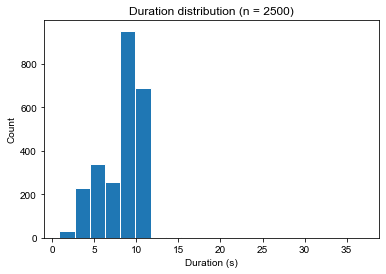

In [10]:
print(f"Number of audio recordings: {len(audio_dict['signals'])}")
print(f"Sample rates: {set(audio_dict['sample_rates'])}")
print(f"Channels: {set(channel_counts)}")
print("=================")
print(f"Mean sample length : {mean_dur}")
print(f"Standard error (s): {std_err}")
print("=================")
print(f"Median sample length (s): {median_dur}")
print(f"10th percentile: {np.quantile(sample_lengths, 0.1)/22050}")
print(f"25th percentile: {np.quantile(sample_lengths, 0.25)/22050}")
print(f"75th percentile: {np.quantile(sample_lengths, 0.75)/22050}")
print(f"90th percentile: {np.quantile(sample_lengths, 0.9)/22050}")
print(f"Min. length: {np.min(sample_lengths)/22050}, Max. length: {np.max(sample_lengths)/22050}")

fix, ax = plt.subplots()
sns.set_theme()
ax.hist(sample_lengths/22050, bins = 20)
ax.set_title(f"Duration distribution (n = {len(audio_dict['signals'])})")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Count")
plt.plot()